In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [3]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import ltcl
import numpy as np
import scipy
from ltcl.datasets.mocap_dataset import MocapTwoSample
from ltcl.modules.srnn_mocap import SRNNSyntheticNS
from ltcl.modules.metrics.correlation import correlation
import random
import seaborn as sns
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from ltcl.tools.utils import load_yaml
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
cfg = load_yaml('../ltcl/configs/mocap.yaml')

In [5]:
num_validation_samples=128
data = MocapTwoSample(directory='/srv/data/ltcl/data/')
# train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(data, batch_size=4500, shuffle=False, pin_memory=True)
# val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [6]:
cfg

{'ROOT': '/srv/data/ltcl/data',
 'LOG': '/srv/data/ltcl/log',
 'DATASET': 'mocap_point_cloud',
 'SPLINE': {'USE_WARM_START': True,
  'TYPE': 'gaussian',
  'STEPS': 5000,
  'LR': 0.001,
  'CUDA': False,
  'BS': 64,
  'LATENT_DIM': 8,
  'BOUND': 5,
  'BINS': 8,
  'ORDER': 'linear',
  'PATH': '/srv/data/ltcl/ckpts/mocap_8.pth'},
 'VAE': {'GPU': [1],
  'CPU': 8,
  'TRAIN_BS': 32,
  'VAL_BS': 128,
  'EPOCHS': 200,
  'N_VAL_SAMPLES': 1280,
  'LAG': 2,
  'LENGTH': 4,
  'NCLASS': 12,
  'TRANS_PRIOR': 'NP',
  'LR': 0.001,
  'BETA': 0.1,
  'GAMMA': 1,
  'SIGMA': 1e-06,
  'L1': 0.001,
  'INPUT_DIM': 62,
  'LATENT_DIM': 8,
  'BIAS': False,
  'ENC': {'HIDDEN_DIM': 128},
  'DEC': {'HIDDEN_DIM': 128, 'DIST': 'gaussian'},
  'PIN': True}}

In [385]:
model = SRNNSyntheticNS.load_from_checkpoint('/srv/data/ltcl/log/weiran/mocap/lightning_logs/version_9/checkpoints/epoch=188-step=25136.ckpt',
                                         input_dim=cfg['VAE']['INPUT_DIM'],
                                        length=cfg['VAE']['LENGTH'],
                                        z_dim=cfg['VAE']['LATENT_DIM'], 
                                        lag=cfg['VAE']['LAG'],
                                        nclass=cfg['VAE']['NCLASS'],
                                        hidden_dim=cfg['VAE']['ENC']['HIDDEN_DIM'],
                                        trans_prior=cfg['VAE']['TRANS_PRIOR'],
                                        bound=cfg['SPLINE']['BOUND'],
                                        count_bins=cfg['SPLINE']['BINS'],
                                        order=cfg['SPLINE']['ORDER'],
                                        beta=cfg['VAE']['BETA'],
                                        gamma=cfg['VAE']['GAMMA'],
                                        sigma=cfg['VAE']['SIGMA'],
                                        lr=cfg['VAE']['LR'],
                                        bias=cfg['VAE']['BIAS'],
                                        use_warm_start=cfg['SPLINE']['USE_WARM_START'],
                                        spline_pth=cfg['SPLINE']['PATH'],
                                        decoder_dist=cfg['VAE']['DEC']['DIST'])

Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow
Load pretrained spline flow


In [38]:
cfg = load_yaml('../ltcl/configs/mocap_bvae.yaml')

In [39]:
from ltcl.baselines.BetaVAE.model import BetaVAE

In [40]:
model = BetaVAE.load_from_checkpoint('/srv/data/ltcl/log/weiran/mocap_bvae/lightning_logs/version_9/checkpoints/epoch=198-step=19302.ckpt',
                                     input_dim=cfg['VAE']['INPUT_DIM'],
                                     z_dim=cfg['VAE']['LATENT_DIM'], 
                                     hidden_dim=cfg['VAE']['ENC']['HIDDEN_DIM'],
                                     beta=cfg['BetaVAE']['BETA'], 
                                     beta1=cfg['BetaVAE']['beta1_VAE'],
                                     beta2=cfg['BetaVAE']['beta2_VAE'],
                                     lr=cfg['BetaVAE']['LR'],
                                     correlation=cfg['MCC']['CORR'])

In [67]:
cfg = load_yaml('../ltcl/configs/mocap_svae.yaml')

In [68]:
from ltcl.baselines.SlowVAE.model import SlowVAE
model = SlowVAE.load_from_checkpoint('/srv/data/ltcl/log/weiran/mocap_svae/lightning_logs/version_4/checkpoints/epoch=198-step=19302.ckpt',
                                    input_dim=cfg['VAE']['INPUT_DIM'],
                z_dim=cfg['VAE']['LATENT_DIM'], 
                hidden_dim=cfg['VAE']['ENC']['HIDDEN_DIM'],
                beta=cfg['SlowVAE']['BETA'], 
                gamma=cfg['SlowVAE']['GAMMA'], 
                beta1=cfg['SlowVAE']['beta1_VAE'],
                beta2=cfg['SlowVAE']['beta2_VAE'],
                lr=cfg['SlowVAE']['LR'],
                rate_prior=cfg['SlowVAE']['RATE_PRIOR'], 
                correlation=cfg['MCC']['CORR'])

/home/weiran/project/ltcl/ltcl/baselines/SlowVAE/net.py:79: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [17]:
batch = next(iter(train_loader))
batch_size = batch['s1']['xt'].shape[0]

In [18]:
latent_size = cfg['VAE']['LATENT_DIM']

In [24]:
batch['s1']['xt'].shape

torch.Size([4364, 6, 62])

In [69]:
x_recon, mu, logvar = model.net(batch['s1']['xt'].view(-1,62))

In [70]:
mu = mu.view(batch_size, -1, latent_size)

In [35]:
# z, mu, logvar = model.forward(batch['s1'])
# mu = mu.view(batch_size, -1, latent_size)

<AxesSubplot:>

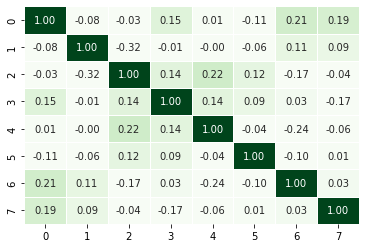

In [71]:
sns.heatmap(np.corrcoef(mu[:,2,:].detach().numpy().T),vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')

In [390]:
zs_flat = z.contiguous().view(-1, model.z_dim)
x_recon = model.dec(zs_flat)
x_recon = x_recon.view(batch_size, -1, model.input_dim)

In [620]:
steps = 100
frame_idx = 10
interpolations = torch.linspace(-8,8,steps)
fixed_frame = mu[frame_idx:frame_idx+1, 0, :].detach()
for latent_idx in range(8):
    x_recon = [ ]
    for val in interpolations:
        new_frame = fixed_frame.clone()
        new_frame[0, latent_idx] = val
        x_recon.append(model.dec(new_frame))
    #     x_recon.append(batch['s1']['xt'][frame_idx,0])
    x_recon = torch.stack(x_recon).squeeze().detach().numpy()
    x_recon = (x_recon * data.std) + data.mean
    np.save('/home/weiran/data/travesal%d'%latent_idx, x_recon)

In [36]:
steps = 100
frame_idx = 10
interpolations = torch.linspace(-8,8,steps)
fixed_frame = mu[frame_idx:frame_idx+1, 0, :].detach()
for latent_idx in range(8):
    x_recon = [ ]
    for val in interpolations:
        new_frame = fixed_frame.clone()
        new_frame[0, latent_idx] = val
        x_recon.append(model.net._decode(new_frame))
    #     x_recon.append(batch['s1']['xt'][frame_idx,0])
    x_recon = torch.stack(x_recon).squeeze().detach().numpy()
    x_recon = (x_recon * data.std) + data.mean
    np.save('/home/weiran/data/slow_travesal%d'%latent_idx, x_recon)

In [391]:
loss = torch.square(x_recon-batch['s1']['xt']).mean(1).mean(1)*model.input_dim

In [392]:
start = 320
end = 630
start = 0
end = 300

In [393]:
anchors = np.array([[0, 310],
[316, 639],
[645, 1054],
[1060, 1503],
[1509, 2020],
[2026, 2437],
[2443, 2816],
[2822, 3178],
[3184, 3484],
[3490, 3785],
[3791, 4100],
[4106, 4363]])

In [394]:
regime = 4
start, end = anchors[regime]

In [395]:
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

In [49]:
figure_path = '/home/weiran/figs/'

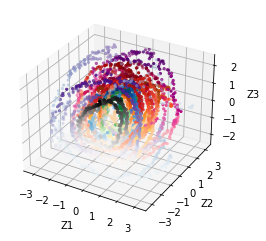

In [617]:
with PdfPages(figure_path + '/mocap_coords.pdf') as pdf:
    ax = plt.axes(projection='3d')
    for regime in range(12):
        start, end = anchors[regime]
        # Data for a three-dimensional line
        xline = z[start:end,0,2].detach().numpy()
        yline = z[start:end,0,3].detach().numpy()
        zline = z[start:end,0,6].detach().numpy()
        ax.scatter3D(xline, yline, zline, c=zline, cmap=cmaps[regime], s=5, label='Trial %d'%(regime+1));
    ax.set_xlabel('Z1')
    ax.set_ylabel('Z2')
    ax.set_zlabel('Z3')
    ax.set_xlim(-3.5,3.5)
    ax.set_ylim(-3.5,3.5)
    ax.set_zlim(-2.5,2.5)
    pdf.savefig(ax.figure, bbox_inches="tight")

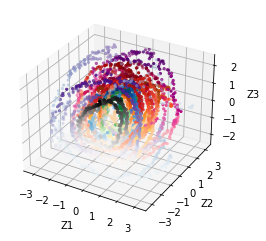

In [458]:
z[:,0].mean(0)

tensor([-0.0101, -0.3023,  0.0363, -0.0800,  0.0208, -0.0132,  0.0008,  0.0061],
       grad_fn=<MeanBackward1>)

In [454]:
logvar[:,0].mean(0)

tensor([-0.0179, -0.6328, -7.4153, -7.1153, -0.1041, -0.1758, -7.2888, -0.0575],
       grad_fn=<MeanBackward1>)

In [72]:
X1 = mu[:,0,[2,3,6]].detach().numpy()
X2 = mu[:,1, [2,3,6]].detach().numpy()
X3 = mu[:,2, [2,3,6]].detach().numpy()

In [73]:
X1 = mu[:,0,:].detach().numpy()
X2 = mu[:,1,:].detach().numpy()
X3 = mu[:,2,:].detach().numpy()

In [74]:
X = np.concatenate((X2.reshape(batch_size,-1), X1.reshape(batch_size,-1)),axis=-1)

In [75]:
from sklearn.linear_model import Lasso, LassoCV

In [76]:
from ltcl.modules.components.pruning import LassoNetRegressor, plot_path

pr_model = LassoNetRegressor(
    hidden_dims=(16,8),
    eps_start=0.1,
    verbose=True,
    device='cpu'
)

In [77]:
path[610].selected.reshape(2,8)[:,4]

tensor([False, False])

In [81]:
len(path)

605

In [87]:
masks = [ ] 
for i in range(X3.shape[-1]):
    y = X3.reshape(batch_size,-1)[:,i]
    path = pr_model.path(X, y)
    tmp = [path[605].selected.reshape(2,8)[:,d] for d in range(8)]
    mask = torch.cat(tmp).detach().numpy()
    masks.append(mask)

Initialized dense model in 158 epochs, val loss 6.12e-03, regularization 2.52e-02
Lambda = 6.12e-04, selected 16 features in 10 epochs
val_objective 6.14e-03, val_loss 6.12e-03, regularization 2.51e-02
Lambda = 6.25e-04, selected 16 features in 10 epochs
val_objective 6.14e-03, val_loss 6.12e-03, regularization 2.51e-02
Lambda = 6.37e-04, selected 16 features in 10 epochs
val_objective 6.13e-03, val_loss 6.12e-03, regularization 2.50e-02
Lambda = 6.50e-04, selected 16 features in 10 epochs
val_objective 6.13e-03, val_loss 6.11e-03, regularization 2.50e-02
Lambda = 6.63e-04, selected 16 features in 10 epochs
val_objective 6.13e-03, val_loss 6.11e-03, regularization 2.49e-02
Lambda = 6.76e-04, selected 16 features in 10 epochs
val_objective 6.12e-03, val_loss 6.11e-03, regularization 2.48e-02
Lambda = 6.90e-04, selected 16 features in 10 epochs
val_objective 6.12e-03, val_loss 6.11e-03, regularization 2.48e-02
Lambda = 7.03e-04, selected 16 features in 10 epochs
val_objective 6.12e-03, v

Lambda = 2.45e-03, selected 16 features in 10 epochs
val_objective 6.10e-03, val_loss 6.06e-03, regularization 1.94e-02
Lambda = 2.50e-03, selected 16 features in 10 epochs
val_objective 6.11e-03, val_loss 6.06e-03, regularization 1.93e-02
Lambda = 2.55e-03, selected 16 features in 10 epochs
val_objective 6.11e-03, val_loss 6.06e-03, regularization 1.92e-02
Lambda = 2.60e-03, selected 16 features in 10 epochs
val_objective 6.11e-03, val_loss 6.06e-03, regularization 1.91e-02
Lambda = 2.65e-03, selected 16 features in 10 epochs
val_objective 6.11e-03, val_loss 6.06e-03, regularization 1.90e-02
Lambda = 2.70e-03, selected 16 features in 10 epochs
val_objective 6.11e-03, val_loss 6.06e-03, regularization 1.89e-02
Lambda = 2.76e-03, selected 16 features in 10 epochs
val_objective 6.11e-03, val_loss 6.06e-03, regularization 1.88e-02
Lambda = 2.81e-03, selected 16 features in 10 epochs
val_objective 6.11e-03, val_loss 6.06e-03, regularization 1.87e-02
Lambda = 2.87e-03, selected 16 features 

Lambda = 9.79e-03, selected 16 features in 10 epochs
val_objective 6.17e-03, val_loss 6.05e-03, regularization 1.16e-02
Lambda = 9.99e-03, selected 16 features in 10 epochs
val_objective 6.17e-03, val_loss 6.05e-03, regularization 1.14e-02
Lambda = 1.02e-02, selected 16 features in 10 epochs
val_objective 6.17e-03, val_loss 6.05e-03, regularization 1.12e-02
Lambda = 1.04e-02, selected 16 features in 10 epochs
val_objective 6.17e-03, val_loss 6.05e-03, regularization 1.10e-02
Lambda = 1.06e-02, selected 16 features in 10 epochs
val_objective 6.17e-03, val_loss 6.05e-03, regularization 1.08e-02
Lambda = 1.08e-02, selected 16 features in 10 epochs
val_objective 6.17e-03, val_loss 6.05e-03, regularization 1.06e-02
Lambda = 1.10e-02, selected 16 features in 10 epochs
val_objective 6.17e-03, val_loss 6.05e-03, regularization 1.04e-02
Lambda = 1.13e-02, selected 16 features in 10 epochs
val_objective 6.17e-03, val_loss 6.05e-03, regularization 1.02e-02
Lambda = 1.15e-02, selected 16 features 

Lambda = 3.84e-02, selected 16 features in 10 epochs
val_objective 6.20e-03, val_loss 6.05e-03, regularization 3.98e-03
Lambda = 3.92e-02, selected 16 features in 10 epochs
val_objective 6.21e-03, val_loss 6.05e-03, regularization 3.98e-03
Lambda = 4.00e-02, selected 16 features in 10 epochs
val_objective 6.21e-03, val_loss 6.05e-03, regularization 3.97e-03
Lambda = 4.08e-02, selected 16 features in 10 epochs
val_objective 6.21e-03, val_loss 6.05e-03, regularization 3.97e-03
Lambda = 4.16e-02, selected 16 features in 10 epochs
val_objective 6.22e-03, val_loss 6.05e-03, regularization 3.97e-03
Lambda = 4.24e-02, selected 16 features in 10 epochs
val_objective 6.22e-03, val_loss 6.05e-03, regularization 3.96e-03
Lambda = 4.32e-02, selected 16 features in 10 epochs
val_objective 6.22e-03, val_loss 6.05e-03, regularization 3.96e-03
Lambda = 4.41e-02, selected 16 features in 10 epochs
val_objective 6.23e-03, val_loss 6.05e-03, regularization 3.95e-03
Lambda = 4.50e-02, selected 16 features 

Lambda = 1.51e-01, selected 16 features in 10 epochs
val_objective 6.60e-03, val_loss 6.06e-03, regularization 3.64e-03
Lambda = 1.54e-01, selected 16 features in 10 epochs
val_objective 6.61e-03, val_loss 6.06e-03, regularization 3.64e-03
Lambda = 1.57e-01, selected 16 features in 10 epochs
val_objective 6.62e-03, val_loss 6.06e-03, regularization 3.63e-03
Lambda = 1.60e-01, selected 16 features in 10 epochs
val_objective 6.64e-03, val_loss 6.06e-03, regularization 3.62e-03
Lambda = 1.63e-01, selected 16 features in 10 epochs
val_objective 6.65e-03, val_loss 6.06e-03, regularization 3.62e-03
Lambda = 1.66e-01, selected 16 features in 10 epochs
val_objective 6.66e-03, val_loss 6.06e-03, regularization 3.61e-03
Lambda = 1.70e-01, selected 16 features in 10 epochs
val_objective 6.67e-03, val_loss 6.06e-03, regularization 3.60e-03
Lambda = 1.73e-01, selected 16 features in 10 epochs
val_objective 6.68e-03, val_loss 6.06e-03, regularization 3.59e-03
Lambda = 1.76e-01, selected 16 features 

Lambda = 5.90e-01, selected 16 features in 10 epochs
val_objective 7.82e-03, val_loss 6.09e-03, regularization 2.92e-03
Lambda = 6.02e-01, selected 16 features in 10 epochs
val_objective 7.84e-03, val_loss 6.09e-03, regularization 2.90e-03
Lambda = 6.14e-01, selected 16 features in 10 epochs
val_objective 7.87e-03, val_loss 6.09e-03, regularization 2.89e-03
Lambda = 6.27e-01, selected 16 features in 10 epochs
val_objective 7.89e-03, val_loss 6.10e-03, regularization 2.87e-03
Lambda = 6.39e-01, selected 16 features in 10 epochs
val_objective 7.92e-03, val_loss 6.10e-03, regularization 2.85e-03
Lambda = 6.52e-01, selected 16 features in 10 epochs
val_objective 7.95e-03, val_loss 6.10e-03, regularization 2.84e-03
Lambda = 6.65e-01, selected 16 features in 10 epochs
val_objective 7.97e-03, val_loss 6.10e-03, regularization 2.82e-03
Lambda = 6.78e-01, selected 16 features in 10 epochs
val_objective 8.00e-03, val_loss 6.10e-03, regularization 2.80e-03
Lambda = 6.92e-01, selected 15 features 

Lambda = 2.46e+00, selected 12 features in 10 epochs
val_objective 1.16e-02, val_loss 6.21e-03, regularization 2.21e-03
Lambda = 2.51e+00, selected 12 features in 10 epochs
val_objective 1.17e-02, val_loss 6.21e-03, regularization 2.20e-03
Lambda = 2.56e+00, selected 12 features in 10 epochs
val_objective 1.18e-02, val_loss 6.21e-03, regularization 2.20e-03
Lambda = 2.61e+00, selected 12 features in 10 epochs
val_objective 1.20e-02, val_loss 6.21e-03, regularization 2.20e-03
Lambda = 2.66e+00, selected 12 features in 10 epochs
val_objective 1.21e-02, val_loss 6.21e-03, regularization 2.20e-03
Lambda = 2.71e+00, selected 12 features in 10 epochs
val_objective 1.22e-02, val_loss 6.21e-03, regularization 2.20e-03
Lambda = 2.77e+00, selected 12 features in 10 epochs
val_objective 1.23e-02, val_loss 6.21e-03, regularization 2.20e-03
Lambda = 2.82e+00, selected 12 features in 10 epochs
val_objective 1.24e-02, val_loss 6.21e-03, regularization 2.20e-03
Lambda = 2.88e+00, selected 12 features 

Lambda = 9.63e+00, selected 10 features in 10 epochs
val_objective 2.60e-02, val_loss 6.38e-03, regularization 2.03e-03
Lambda = 9.83e+00, selected 10 features in 10 epochs
val_objective 2.63e-02, val_loss 6.38e-03, regularization 2.03e-03
Lambda = 1.00e+01, selected 10 features in 10 epochs
val_objective 2.67e-02, val_loss 6.39e-03, regularization 2.03e-03
Lambda = 1.02e+01, selected 10 features in 10 epochs
val_objective 2.71e-02, val_loss 6.39e-03, regularization 2.02e-03
Lambda = 1.04e+01, selected 10 features in 10 epochs
val_objective 2.74e-02, val_loss 6.40e-03, regularization 2.02e-03
Lambda = 1.06e+01, selected 10 features in 10 epochs
val_objective 2.78e-02, val_loss 6.40e-03, regularization 2.01e-03
Lambda = 1.08e+01, selected 10 features in 10 epochs
val_objective 2.82e-02, val_loss 6.41e-03, regularization 2.01e-03
Lambda = 1.11e+01, selected 10 features in 10 epochs
val_objective 2.86e-02, val_loss 6.42e-03, regularization 2.00e-03
Lambda = 1.13e+01, selected 10 features 

Lambda = 3.78e+01, selected 2 features in 10 epochs
val_objective 7.52e-02, val_loss 6.74e-03, regularization 1.81e-03
Lambda = 3.85e+01, selected 2 features in 10 epochs
val_objective 7.64e-02, val_loss 6.75e-03, regularization 1.81e-03
Lambda = 3.93e+01, selected 2 features in 10 epochs
val_objective 7.77e-02, val_loss 6.76e-03, regularization 1.80e-03
Lambda = 4.01e+01, selected 2 features in 10 epochs
val_objective 7.90e-02, val_loss 6.77e-03, regularization 1.80e-03
Lambda = 4.09e+01, selected 2 features in 10 epochs
val_objective 8.03e-02, val_loss 6.78e-03, regularization 1.80e-03
Lambda = 4.17e+01, selected 2 features in 10 epochs
val_objective 8.17e-02, val_loss 6.79e-03, regularization 1.80e-03
Lambda = 4.25e+01, selected 2 features in 10 epochs
val_objective 8.30e-02, val_loss 6.80e-03, regularization 1.79e-03
Lambda = 4.34e+01, selected 2 features in 10 epochs
val_objective 8.44e-02, val_loss 6.82e-03, regularization 1.79e-03
Lambda = 4.43e+01, selected 2 features in 10 epo

Lambda = 1.60e+02, selected 2 features in 10 epochs
val_objective 2.24e-01, val_loss 1.08e-02, regularization 1.33e-03
Lambda = 1.64e+02, selected 2 features in 10 epochs
val_objective 2.27e-01, val_loss 1.10e-02, regularization 1.32e-03
Lambda = 1.67e+02, selected 2 features in 10 epochs
val_objective 2.29e-01, val_loss 1.12e-02, regularization 1.31e-03
Lambda = 1.70e+02, selected 2 features in 10 epochs
val_objective 2.31e-01, val_loss 1.14e-02, regularization 1.29e-03
Lambda = 1.74e+02, selected 2 features in 10 epochs
val_objective 2.34e-01, val_loss 1.16e-02, regularization 1.28e-03
Lambda = 1.77e+02, selected 2 features in 10 epochs
val_objective 2.36e-01, val_loss 1.18e-02, regularization 1.27e-03
Lambda = 1.81e+02, selected 2 features in 10 epochs
val_objective 2.38e-01, val_loss 1.20e-02, regularization 1.25e-03
Lambda = 1.84e+02, selected 2 features in 10 epochs
val_objective 2.41e-01, val_loss 1.22e-02, regularization 1.24e-03
Lambda = 1.88e+02, selected 2 features in 10 epo

Lambda = 2.07e-04, selected 16 features in 10 epochs
val_objective 1.88e-03, val_loss 1.88e-03, regularization 2.78e-02
Lambda = 2.12e-04, selected 16 features in 10 epochs
val_objective 1.88e-03, val_loss 1.88e-03, regularization 2.78e-02
Lambda = 2.16e-04, selected 16 features in 10 epochs
val_objective 1.88e-03, val_loss 1.88e-03, regularization 2.78e-02
Lambda = 2.20e-04, selected 16 features in 10 epochs
val_objective 1.88e-03, val_loss 1.88e-03, regularization 2.78e-02
Lambda = 2.25e-04, selected 16 features in 10 epochs
val_objective 1.88e-03, val_loss 1.88e-03, regularization 2.78e-02
Lambda = 2.29e-04, selected 16 features in 10 epochs
val_objective 1.88e-03, val_loss 1.88e-03, regularization 2.78e-02
Lambda = 2.34e-04, selected 16 features in 10 epochs
val_objective 1.88e-03, val_loss 1.88e-03, regularization 2.77e-02
Lambda = 2.38e-04, selected 16 features in 10 epochs
val_objective 1.88e-03, val_loss 1.88e-03, regularization 2.77e-02
Lambda = 2.43e-04, selected 16 features 

Lambda = 9.16e-04, selected 16 features in 10 epochs
val_objective 1.91e-03, val_loss 1.89e-03, regularization 2.38e-02
Lambda = 9.34e-04, selected 16 features in 10 epochs
val_objective 1.91e-03, val_loss 1.89e-03, regularization 2.37e-02
Lambda = 9.53e-04, selected 16 features in 10 epochs
val_objective 1.91e-03, val_loss 1.89e-03, regularization 2.36e-02
Lambda = 9.72e-04, selected 16 features in 10 epochs
val_objective 1.91e-03, val_loss 1.89e-03, regularization 2.35e-02
Lambda = 9.92e-04, selected 16 features in 10 epochs
val_objective 1.92e-03, val_loss 1.89e-03, regularization 2.34e-02
Lambda = 1.01e-03, selected 16 features in 10 epochs
val_objective 1.92e-03, val_loss 1.89e-03, regularization 2.33e-02
Lambda = 1.03e-03, selected 16 features in 10 epochs
val_objective 1.92e-03, val_loss 1.89e-03, regularization 2.32e-02
Lambda = 1.05e-03, selected 16 features in 10 epochs
val_objective 1.92e-03, val_loss 1.89e-03, regularization 2.31e-02
Lambda = 1.07e-03, selected 16 features 

Lambda = 3.74e-03, selected 16 features in 10 epochs
val_objective 1.96e-03, val_loss 1.90e-03, regularization 1.68e-02
Lambda = 3.81e-03, selected 16 features in 10 epochs
val_objective 1.96e-03, val_loss 1.90e-03, regularization 1.68e-02
Lambda = 3.89e-03, selected 16 features in 10 epochs
val_objective 1.96e-03, val_loss 1.90e-03, regularization 1.67e-02
Lambda = 3.97e-03, selected 16 features in 10 epochs
val_objective 1.96e-03, val_loss 1.90e-03, regularization 1.66e-02
Lambda = 4.04e-03, selected 16 features in 10 epochs
val_objective 1.96e-03, val_loss 1.90e-03, regularization 1.65e-02
Lambda = 4.13e-03, selected 16 features in 10 epochs
val_objective 1.96e-03, val_loss 1.90e-03, regularization 1.64e-02
Lambda = 4.21e-03, selected 16 features in 10 epochs
val_objective 1.97e-03, val_loss 1.90e-03, regularization 1.64e-02
Lambda = 4.29e-03, selected 16 features in 10 epochs
val_objective 1.97e-03, val_loss 1.90e-03, regularization 1.63e-02
Lambda = 4.38e-03, selected 16 features 

Lambda = 1.47e-02, selected 16 features in 10 epochs
val_objective 2.03e-03, val_loss 1.90e-03, regularization 9.20e-03
Lambda = 1.49e-02, selected 16 features in 10 epochs
val_objective 2.03e-03, val_loss 1.90e-03, regularization 9.05e-03
Lambda = 1.52e-02, selected 16 features in 10 epochs
val_objective 2.03e-03, val_loss 1.90e-03, regularization 8.90e-03
Lambda = 1.55e-02, selected 16 features in 10 epochs
val_objective 2.03e-03, val_loss 1.90e-03, regularization 8.74e-03
Lambda = 1.59e-02, selected 16 features in 10 epochs
val_objective 2.03e-03, val_loss 1.90e-03, regularization 8.58e-03
Lambda = 1.62e-02, selected 16 features in 10 epochs
val_objective 2.03e-03, val_loss 1.90e-03, regularization 8.42e-03
Lambda = 1.65e-02, selected 16 features in 10 epochs
val_objective 2.03e-03, val_loss 1.90e-03, regularization 8.25e-03
Lambda = 1.68e-02, selected 16 features in 10 epochs
val_objective 2.03e-03, val_loss 1.90e-03, regularization 8.08e-03
Lambda = 1.72e-02, selected 16 features 

Lambda = 5.86e-02, selected 15 features in 10 epochs
val_objective 2.08e-03, val_loss 1.90e-03, regularization 3.16e-03
Lambda = 5.98e-02, selected 15 features in 10 epochs
val_objective 2.09e-03, val_loss 1.90e-03, regularization 3.16e-03
Lambda = 6.10e-02, selected 15 features in 10 epochs
val_objective 2.09e-03, val_loss 1.90e-03, regularization 3.15e-03
Lambda = 6.22e-02, selected 15 features in 10 epochs
val_objective 2.09e-03, val_loss 1.90e-03, regularization 3.15e-03
Lambda = 6.34e-02, selected 15 features in 10 epochs
val_objective 2.10e-03, val_loss 1.90e-03, regularization 3.15e-03
Lambda = 6.47e-02, selected 15 features in 10 epochs
val_objective 2.10e-03, val_loss 1.90e-03, regularization 3.14e-03
Lambda = 6.60e-02, selected 15 features in 10 epochs
val_objective 2.10e-03, val_loss 1.90e-03, regularization 3.14e-03
Lambda = 6.73e-02, selected 15 features in 10 epochs
val_objective 2.11e-03, val_loss 1.90e-03, regularization 3.13e-03
Lambda = 6.87e-02, selected 15 features 

Lambda = 2.64e-01, selected 16 features in 10 epochs
val_objective 2.63e-03, val_loss 1.90e-03, regularization 2.76e-03
Lambda = 2.69e-01, selected 16 features in 10 epochs
val_objective 2.64e-03, val_loss 1.90e-03, regularization 2.76e-03
Lambda = 2.75e-01, selected 16 features in 10 epochs
val_objective 2.65e-03, val_loss 1.90e-03, regularization 2.75e-03
Lambda = 2.80e-01, selected 16 features in 10 epochs
val_objective 2.67e-03, val_loss 1.90e-03, regularization 2.74e-03
Lambda = 2.86e-01, selected 16 features in 10 epochs
val_objective 2.68e-03, val_loss 1.90e-03, regularization 2.73e-03
Lambda = 2.91e-01, selected 16 features in 10 epochs
val_objective 2.69e-03, val_loss 1.90e-03, regularization 2.72e-03
Lambda = 2.97e-01, selected 16 features in 10 epochs
val_objective 2.71e-03, val_loss 1.90e-03, regularization 2.72e-03
Lambda = 3.03e-01, selected 16 features in 10 epochs
val_objective 2.72e-03, val_loss 1.90e-03, regularization 2.71e-03
Lambda = 3.09e-01, selected 16 features 

Lambda = 1.06e+00, selected 11 features in 10 epochs
val_objective 4.19e-03, val_loss 1.92e-03, regularization 2.15e-03
Lambda = 1.08e+00, selected 11 features in 10 epochs
val_objective 4.24e-03, val_loss 1.92e-03, regularization 2.15e-03
Lambda = 1.10e+00, selected 11 features in 10 epochs
val_objective 4.28e-03, val_loss 1.92e-03, regularization 2.15e-03
Lambda = 1.12e+00, selected 11 features in 10 epochs
val_objective 4.33e-03, val_loss 1.92e-03, regularization 2.15e-03
Lambda = 1.14e+00, selected 11 features in 10 epochs
val_objective 4.38e-03, val_loss 1.92e-03, regularization 2.15e-03
Lambda = 1.17e+00, selected 11 features in 10 epochs
val_objective 4.43e-03, val_loss 1.92e-03, regularization 2.15e-03
Lambda = 1.19e+00, selected 11 features in 10 epochs
val_objective 4.47e-03, val_loss 1.92e-03, regularization 2.15e-03
Lambda = 1.21e+00, selected 11 features in 10 epochs
val_objective 4.52e-03, val_loss 1.92e-03, regularization 2.14e-03
Lambda = 1.24e+00, selected 11 features 

Lambda = 4.22e+00, selected 9 features in 10 epochs
val_objective 1.07e-02, val_loss 1.94e-03, regularization 2.07e-03
Lambda = 4.31e+00, selected 8 features in 10 epochs
val_objective 1.08e-02, val_loss 1.94e-03, regularization 2.06e-03
Lambda = 4.39e+00, selected 8 features in 10 epochs
val_objective 1.10e-02, val_loss 1.94e-03, regularization 2.06e-03
Lambda = 4.48e+00, selected 8 features in 10 epochs
val_objective 1.12e-02, val_loss 1.94e-03, regularization 2.06e-03
Lambda = 4.57e+00, selected 8 features in 10 epochs
val_objective 1.14e-02, val_loss 1.94e-03, regularization 2.06e-03
Lambda = 4.66e+00, selected 8 features in 10 epochs
val_objective 1.15e-02, val_loss 1.94e-03, regularization 2.06e-03
Lambda = 4.76e+00, selected 8 features in 10 epochs
val_objective 1.17e-02, val_loss 1.94e-03, regularization 2.06e-03
Lambda = 4.85e+00, selected 8 features in 10 epochs
val_objective 1.19e-02, val_loss 1.95e-03, regularization 2.05e-03
Lambda = 4.95e+00, selected 8 features in 10 epo

Lambda = 1.72e+01, selected 4 features in 10 epochs
val_objective 3.52e-02, val_loss 2.06e-03, regularization 1.92e-03
Lambda = 1.76e+01, selected 4 features in 10 epochs
val_objective 3.58e-02, val_loss 2.06e-03, regularization 1.92e-03
Lambda = 1.79e+01, selected 4 features in 10 epochs
val_objective 3.64e-02, val_loss 2.07e-03, regularization 1.92e-03
Lambda = 1.83e+01, selected 4 features in 10 epochs
val_objective 3.71e-02, val_loss 2.07e-03, regularization 1.91e-03
Lambda = 1.86e+01, selected 4 features in 10 epochs
val_objective 3.77e-02, val_loss 2.08e-03, regularization 1.91e-03
Lambda = 1.90e+01, selected 4 features in 10 epochs
val_objective 3.84e-02, val_loss 2.08e-03, regularization 1.91e-03
Lambda = 1.94e+01, selected 4 features in 10 epochs
val_objective 3.91e-02, val_loss 2.08e-03, regularization 1.91e-03
Lambda = 1.98e+01, selected 4 features in 10 epochs
val_objective 3.98e-02, val_loss 2.09e-03, regularization 1.90e-03
Lambda = 2.02e+01, selected 4 features in 10 epo

Lambda = 6.89e+01, selected 1 features in 10 epochs
val_objective 1.24e-01, val_loss 2.56e-03, regularization 1.77e-03
Lambda = 7.03e+01, selected 1 features in 10 epochs
val_objective 1.27e-01, val_loss 2.58e-03, regularization 1.76e-03
Lambda = 7.17e+01, selected 1 features in 10 epochs
val_objective 1.29e-01, val_loss 2.60e-03, regularization 1.76e-03
Lambda = 7.31e+01, selected 1 features in 10 epochs
val_objective 1.31e-01, val_loss 2.62e-03, regularization 1.76e-03
Lambda = 7.46e+01, selected 1 features in 10 epochs
val_objective 1.33e-01, val_loss 2.64e-03, regularization 1.75e-03
Lambda = 7.61e+01, selected 1 features in 10 epochs
val_objective 1.36e-01, val_loss 2.67e-03, regularization 1.75e-03
Lambda = 7.76e+01, selected 1 features in 10 epochs
val_objective 1.38e-01, val_loss 2.69e-03, regularization 1.75e-03
Lambda = 7.91e+01, selected 1 features in 10 epochs
val_objective 1.41e-01, val_loss 2.72e-03, regularization 1.74e-03
Lambda = 8.07e+01, selected 1 features in 10 epo

Lambda = 2.70e+02, selected 1 features in 10 epochs
val_objective 3.68e-01, val_loss 9.58e-03, regularization 1.33e-03
Lambda = 2.76e+02, selected 1 features in 10 epochs
val_objective 3.72e-01, val_loss 9.88e-03, regularization 1.32e-03
Lambda = 2.81e+02, selected 1 features in 10 epochs
val_objective 3.77e-01, val_loss 1.02e-02, regularization 1.30e-03
Lambda = 2.87e+02, selected 1 features in 10 epochs
val_objective 3.81e-01, val_loss 1.05e-02, regularization 1.29e-03
Lambda = 2.92e+02, selected 1 features in 10 epochs
val_objective 3.85e-01, val_loss 1.09e-02, regularization 1.28e-03
Lambda = 2.98e+02, selected 1 features in 10 epochs
val_objective 3.90e-01, val_loss 1.12e-02, regularization 1.27e-03
Lambda = 3.04e+02, selected 1 features in 10 epochs
val_objective 3.94e-01, val_loss 1.16e-02, regularization 1.26e-03
Lambda = 3.10e+02, selected 1 features in 10 epochs
val_objective 3.98e-01, val_loss 1.19e-02, regularization 1.24e-03
Lambda = 3.17e+02, selected 1 features in 10 epo

Lambda = 2.67e-04, selected 16 features in 10 epochs
val_objective 2.47e-03, val_loss 2.46e-03, regularization 3.04e-02
Lambda = 2.72e-04, selected 16 features in 10 epochs
val_objective 2.47e-03, val_loss 2.46e-03, regularization 3.03e-02
Lambda = 2.78e-04, selected 16 features in 10 epochs
val_objective 2.47e-03, val_loss 2.46e-03, regularization 3.03e-02
Lambda = 2.83e-04, selected 16 features in 10 epochs
val_objective 2.47e-03, val_loss 2.46e-03, regularization 3.03e-02
Lambda = 2.89e-04, selected 16 features in 10 epochs
val_objective 2.47e-03, val_loss 2.46e-03, regularization 3.03e-02
Lambda = 2.94e-04, selected 16 features in 10 epochs
val_objective 2.47e-03, val_loss 2.46e-03, regularization 3.02e-02
Lambda = 3.00e-04, selected 16 features in 10 epochs
val_objective 2.47e-03, val_loss 2.46e-03, regularization 3.02e-02
Lambda = 3.06e-04, selected 16 features in 10 epochs
val_objective 2.47e-03, val_loss 2.46e-03, regularization 3.02e-02
Lambda = 3.13e-04, selected 16 features 

Lambda = 1.05e-03, selected 16 features in 10 epochs
val_objective 2.49e-03, val_loss 2.46e-03, regularization 2.47e-02
Lambda = 1.07e-03, selected 16 features in 10 epochs
val_objective 2.49e-03, val_loss 2.46e-03, regularization 2.45e-02
Lambda = 1.09e-03, selected 16 features in 10 epochs
val_objective 2.49e-03, val_loss 2.46e-03, regularization 2.43e-02
Lambda = 1.11e-03, selected 16 features in 10 epochs
val_objective 2.49e-03, val_loss 2.46e-03, regularization 2.41e-02
Lambda = 1.13e-03, selected 16 features in 10 epochs
val_objective 2.49e-03, val_loss 2.46e-03, regularization 2.40e-02
Lambda = 1.15e-03, selected 16 features in 10 epochs
val_objective 2.49e-03, val_loss 2.46e-03, regularization 2.38e-02
Lambda = 1.18e-03, selected 16 features in 10 epochs
val_objective 2.49e-03, val_loss 2.46e-03, regularization 2.36e-02
Lambda = 1.20e-03, selected 16 features in 10 epochs
val_objective 2.49e-03, val_loss 2.46e-03, regularization 2.34e-02
Lambda = 1.23e-03, selected 16 features 

Lambda = 4.35e-03, selected 16 features in 10 epochs
val_objective 2.53e-03, val_loss 2.47e-03, regularization 1.57e-02
Lambda = 4.44e-03, selected 16 features in 10 epochs
val_objective 2.53e-03, val_loss 2.47e-03, regularization 1.57e-02
Lambda = 4.53e-03, selected 16 features in 10 epochs
val_objective 2.54e-03, val_loss 2.47e-03, regularization 1.57e-02
Lambda = 4.62e-03, selected 16 features in 10 epochs
val_objective 2.54e-03, val_loss 2.47e-03, regularization 1.56e-02
Lambda = 4.71e-03, selected 16 features in 10 epochs
val_objective 2.54e-03, val_loss 2.47e-03, regularization 1.56e-02
Lambda = 4.80e-03, selected 16 features in 10 epochs
val_objective 2.54e-03, val_loss 2.47e-03, regularization 1.55e-02
Lambda = 4.90e-03, selected 16 features in 10 epochs
val_objective 2.54e-03, val_loss 2.47e-03, regularization 1.55e-02
Lambda = 5.00e-03, selected 16 features in 10 epochs
val_objective 2.54e-03, val_loss 2.47e-03, regularization 1.54e-02
Lambda = 5.10e-03, selected 16 features 

Lambda = 1.81e-02, selected 16 features in 10 epochs
val_objective 2.62e-03, val_loss 2.47e-03, regularization 8.67e-03
Lambda = 1.85e-02, selected 16 features in 10 epochs
val_objective 2.62e-03, val_loss 2.47e-03, regularization 8.48e-03
Lambda = 1.88e-02, selected 16 features in 10 epochs
val_objective 2.62e-03, val_loss 2.47e-03, regularization 8.29e-03
Lambda = 1.92e-02, selected 16 features in 10 epochs
val_objective 2.62e-03, val_loss 2.47e-03, regularization 8.10e-03
Lambda = 1.96e-02, selected 16 features in 10 epochs
val_objective 2.62e-03, val_loss 2.47e-03, regularization 7.90e-03
Lambda = 2.00e-02, selected 16 features in 10 epochs
val_objective 2.62e-03, val_loss 2.47e-03, regularization 7.70e-03
Lambda = 2.04e-02, selected 16 features in 10 epochs
val_objective 2.62e-03, val_loss 2.47e-03, regularization 7.49e-03
Lambda = 2.08e-02, selected 16 features in 10 epochs
val_objective 2.62e-03, val_loss 2.47e-03, regularization 7.28e-03
Lambda = 2.12e-02, selected 16 features 

Lambda = 7.84e-02, selected 16 features in 10 epochs
val_objective 2.73e-03, val_loss 2.46e-03, regularization 3.41e-03
Lambda = 8.00e-02, selected 16 features in 10 epochs
val_objective 2.73e-03, val_loss 2.46e-03, regularization 3.40e-03
Lambda = 8.16e-02, selected 16 features in 10 epochs
val_objective 2.74e-03, val_loss 2.46e-03, regularization 3.40e-03
Lambda = 8.32e-02, selected 16 features in 10 epochs
val_objective 2.74e-03, val_loss 2.46e-03, regularization 3.39e-03
Lambda = 8.49e-02, selected 16 features in 10 epochs
val_objective 2.75e-03, val_loss 2.46e-03, regularization 3.39e-03
Lambda = 8.66e-02, selected 16 features in 10 epochs
val_objective 2.75e-03, val_loss 2.46e-03, regularization 3.38e-03
Lambda = 8.83e-02, selected 16 features in 10 epochs
val_objective 2.76e-03, val_loss 2.46e-03, regularization 3.38e-03
Lambda = 9.01e-02, selected 16 features in 10 epochs
val_objective 2.77e-03, val_loss 2.46e-03, regularization 3.37e-03
Lambda = 9.19e-02, selected 16 features 

Lambda = 3.26e-01, selected 14 features in 10 epochs
val_objective 3.42e-03, val_loss 2.46e-03, regularization 2.94e-03
Lambda = 3.33e-01, selected 14 features in 10 epochs
val_objective 3.43e-03, val_loss 2.46e-03, regularization 2.93e-03
Lambda = 3.39e-01, selected 14 features in 10 epochs
val_objective 3.45e-03, val_loss 2.46e-03, regularization 2.92e-03
Lambda = 3.46e-01, selected 14 features in 10 epochs
val_objective 3.47e-03, val_loss 2.46e-03, regularization 2.91e-03
Lambda = 3.53e-01, selected 14 features in 10 epochs
val_objective 3.48e-03, val_loss 2.46e-03, regularization 2.90e-03
Lambda = 3.60e-01, selected 14 features in 10 epochs
val_objective 3.50e-03, val_loss 2.46e-03, regularization 2.89e-03
Lambda = 3.67e-01, selected 14 features in 10 epochs
val_objective 3.52e-03, val_loss 2.46e-03, regularization 2.88e-03
Lambda = 3.75e-01, selected 14 features in 10 epochs
val_objective 3.53e-03, val_loss 2.46e-03, regularization 2.87e-03
Lambda = 3.82e-01, selected 14 features 

Lambda = 1.28e+00, selected 13 features in 10 epochs
val_objective 5.27e-03, val_loss 2.45e-03, regularization 2.20e-03
Lambda = 1.30e+00, selected 12 features in 10 epochs
val_objective 5.32e-03, val_loss 2.46e-03, regularization 2.19e-03
Lambda = 1.33e+00, selected 12 features in 10 epochs
val_objective 5.37e-03, val_loss 2.46e-03, regularization 2.19e-03
Lambda = 1.36e+00, selected 12 features in 10 epochs
val_objective 5.42e-03, val_loss 2.46e-03, regularization 2.19e-03
Lambda = 1.38e+00, selected 12 features in 10 epochs
val_objective 5.48e-03, val_loss 2.46e-03, regularization 2.18e-03
Lambda = 1.41e+00, selected 12 features in 10 epochs
val_objective 5.54e-03, val_loss 2.46e-03, regularization 2.18e-03
Lambda = 1.44e+00, selected 12 features in 10 epochs
val_objective 5.59e-03, val_loss 2.46e-03, regularization 2.18e-03
Lambda = 1.47e+00, selected 12 features in 10 epochs
val_objective 5.65e-03, val_loss 2.46e-03, regularization 2.17e-03
Lambda = 1.50e+00, selected 12 features 

Lambda = 5.02e+00, selected 7 features in 10 epochs
val_objective 1.20e-02, val_loss 2.54e-03, regularization 1.88e-03
Lambda = 5.12e+00, selected 7 features in 10 epochs
val_objective 1.22e-02, val_loss 2.54e-03, regularization 1.88e-03
Lambda = 5.22e+00, selected 7 features in 10 epochs
val_objective 1.23e-02, val_loss 2.54e-03, regularization 1.88e-03
Lambda = 5.32e+00, selected 7 features in 10 epochs
val_objective 1.25e-02, val_loss 2.55e-03, regularization 1.88e-03
Lambda = 5.43e+00, selected 7 features in 10 epochs
val_objective 1.27e-02, val_loss 2.55e-03, regularization 1.88e-03
Lambda = 5.54e+00, selected 7 features in 10 epochs
val_objective 1.29e-02, val_loss 2.55e-03, regularization 1.87e-03
Lambda = 5.65e+00, selected 7 features in 10 epochs
val_objective 1.31e-02, val_loss 2.55e-03, regularization 1.87e-03
Lambda = 5.76e+00, selected 7 features in 10 epochs
val_objective 1.33e-02, val_loss 2.55e-03, regularization 1.87e-03
Lambda = 5.88e+00, selected 7 features in 10 epo

Lambda = 1.97e+01, selected 3 features in 10 epochs
val_objective 3.79e-02, val_loss 2.61e-03, regularization 1.80e-03
Lambda = 2.01e+01, selected 3 features in 10 epochs
val_objective 3.86e-02, val_loss 2.61e-03, regularization 1.80e-03
Lambda = 2.05e+01, selected 3 features in 10 epochs
val_objective 3.93e-02, val_loss 2.61e-03, regularization 1.79e-03
Lambda = 2.09e+01, selected 3 features in 10 epochs
val_objective 4.00e-02, val_loss 2.62e-03, regularization 1.79e-03
Lambda = 2.13e+01, selected 3 features in 10 epochs
val_objective 4.07e-02, val_loss 2.62e-03, regularization 1.79e-03
Lambda = 2.17e+01, selected 3 features in 10 epochs
val_objective 4.15e-02, val_loss 2.62e-03, regularization 1.79e-03
Lambda = 2.21e+01, selected 3 features in 10 epochs
val_objective 4.22e-02, val_loss 2.62e-03, regularization 1.79e-03
Lambda = 2.26e+01, selected 3 features in 10 epochs
val_objective 4.30e-02, val_loss 2.62e-03, regularization 1.79e-03
Lambda = 2.30e+01, selected 3 features in 10 epo

Lambda = 7.87e+01, selected 1 features in 10 epochs
val_objective 1.34e-01, val_loss 3.06e-03, regularization 1.66e-03
Lambda = 8.02e+01, selected 1 features in 10 epochs
val_objective 1.36e-01, val_loss 3.07e-03, regularization 1.66e-03
Lambda = 8.18e+01, selected 1 features in 10 epochs
val_objective 1.39e-01, val_loss 3.09e-03, regularization 1.66e-03
Lambda = 8.35e+01, selected 1 features in 10 epochs
val_objective 1.41e-01, val_loss 3.11e-03, regularization 1.65e-03
Lambda = 8.51e+01, selected 1 features in 10 epochs
val_objective 1.44e-01, val_loss 3.12e-03, regularization 1.65e-03
Lambda = 8.69e+01, selected 1 features in 10 epochs
val_objective 1.46e-01, val_loss 3.14e-03, regularization 1.65e-03
Lambda = 8.86e+01, selected 1 features in 10 epochs
val_objective 1.49e-01, val_loss 3.16e-03, regularization 1.65e-03
Lambda = 9.04e+01, selected 1 features in 10 epochs
val_objective 1.52e-01, val_loss 3.18e-03, regularization 1.64e-03
Lambda = 9.22e+01, selected 1 features in 10 epo

Lambda = 3.15e+02, selected 1 features in 10 epochs
val_objective 4.23e-01, val_loss 9.02e-03, regularization 1.32e-03
Lambda = 3.21e+02, selected 1 features in 10 epochs
val_objective 4.29e-01, val_loss 9.27e-03, regularization 1.31e-03
Lambda = 3.27e+02, selected 1 features in 10 epochs
val_objective 4.34e-01, val_loss 9.53e-03, regularization 1.30e-03
Lambda = 3.34e+02, selected 1 features in 10 epochs
val_objective 4.40e-01, val_loss 9.81e-03, regularization 1.29e-03
Lambda = 3.41e+02, selected 1 features in 10 epochs
val_objective 4.46e-01, val_loss 1.01e-02, regularization 1.28e-03
Lambda = 3.47e+02, selected 1 features in 10 epochs
val_objective 4.52e-01, val_loss 1.04e-02, regularization 1.27e-03
Lambda = 3.54e+02, selected 1 features in 10 epochs
val_objective 4.57e-01, val_loss 1.07e-02, regularization 1.26e-03
Lambda = 3.61e+02, selected 1 features in 10 epochs
val_objective 4.63e-01, val_loss 1.10e-02, regularization 1.25e-03
Lambda = 3.69e+02, selected 1 features in 10 epo

Lambda = 1.23e+03, selected 1 features in 17 epochs
val_objective 3.62e-01, val_loss 8.76e-02, regularization 2.22e-04
Lambda = 1.26e+03, selected 1 features in 17 epochs
val_objective 3.36e-01, val_loss 9.10e-02, regularization 1.95e-04
Lambda = 1.28e+03, selected 1 features in 18 epochs
val_objective 3.14e-01, val_loss 9.39e-02, regularization 1.72e-04
Lambda = 1.31e+03, selected 1 features in 18 epochs
val_objective 2.86e-01, val_loss 9.74e-02, regularization 1.44e-04
Lambda = 1.34e+03, selected 1 features in 18 epochs
val_objective 2.54e-01, val_loss 1.01e-01, regularization 1.14e-04
Lambda = 1.36e+03, selected 1 features in 18 epochs
val_objective 2.20e-01, val_loss 1.05e-01, regularization 8.43e-05
Lambda = 1.39e+03, selected 1 features in 18 epochs
val_objective 1.84e-01, val_loss 1.09e-01, regularization 5.39e-05
Lambda = 1.42e+03, selected 0 features in 14 epochs
val_objective 1.17e-01, val_loss 1.17e-01, regularization 0.00e+00
Initialized dense model in 599 epochs, val loss 

Lambda = 6.76e-04, selected 16 features in 10 epochs
val_objective 2.04e-03, val_loss 2.02e-03, regularization 2.67e-02
Lambda = 6.89e-04, selected 16 features in 10 epochs
val_objective 2.04e-03, val_loss 2.02e-03, regularization 2.66e-02
Lambda = 7.03e-04, selected 16 features in 10 epochs
val_objective 2.04e-03, val_loss 2.02e-03, regularization 2.65e-02
Lambda = 7.17e-04, selected 16 features in 10 epochs
val_objective 2.04e-03, val_loss 2.02e-03, regularization 2.64e-02
Lambda = 7.31e-04, selected 16 features in 10 epochs
val_objective 2.04e-03, val_loss 2.02e-03, regularization 2.63e-02
Lambda = 7.46e-04, selected 16 features in 10 epochs
val_objective 2.04e-03, val_loss 2.02e-03, regularization 2.61e-02
Lambda = 7.61e-04, selected 16 features in 10 epochs
val_objective 2.04e-03, val_loss 2.02e-03, regularization 2.60e-02
Lambda = 7.76e-04, selected 16 features in 10 epochs
val_objective 2.04e-03, val_loss 2.02e-03, regularization 2.59e-02
Lambda = 7.91e-04, selected 16 features 

Lambda = 2.65e-03, selected 16 features in 10 epochs
val_objective 2.06e-03, val_loss 2.02e-03, regularization 1.53e-02
Lambda = 2.70e-03, selected 16 features in 10 epochs
val_objective 2.06e-03, val_loss 2.02e-03, regularization 1.52e-02
Lambda = 2.76e-03, selected 16 features in 10 epochs
val_objective 2.06e-03, val_loss 2.02e-03, regularization 1.50e-02
Lambda = 2.81e-03, selected 16 features in 10 epochs
val_objective 2.06e-03, val_loss 2.02e-03, regularization 1.50e-02
Lambda = 2.87e-03, selected 16 features in 10 epochs
val_objective 2.06e-03, val_loss 2.02e-03, regularization 1.49e-02
Lambda = 2.92e-03, selected 16 features in 10 epochs
val_objective 2.06e-03, val_loss 2.02e-03, regularization 1.48e-02
Lambda = 2.98e-03, selected 16 features in 10 epochs
val_objective 2.06e-03, val_loss 2.02e-03, regularization 1.47e-02
Lambda = 3.04e-03, selected 16 features in 10 epochs
val_objective 2.06e-03, val_loss 2.02e-03, regularization 1.46e-02
Lambda = 3.10e-03, selected 16 features 

Lambda = 1.06e-02, selected 16 features in 10 epochs
val_objective 2.13e-03, val_loss 2.02e-03, regularization 1.04e-02
Lambda = 1.08e-02, selected 16 features in 10 epochs
val_objective 2.13e-03, val_loss 2.02e-03, regularization 1.03e-02
Lambda = 1.10e-02, selected 16 features in 10 epochs
val_objective 2.13e-03, val_loss 2.02e-03, regularization 1.02e-02
Lambda = 1.12e-02, selected 16 features in 10 epochs
val_objective 2.13e-03, val_loss 2.02e-03, regularization 1.01e-02
Lambda = 1.15e-02, selected 16 features in 10 epochs
val_objective 2.13e-03, val_loss 2.02e-03, regularization 9.97e-03
Lambda = 1.17e-02, selected 16 features in 10 epochs
val_objective 2.13e-03, val_loss 2.02e-03, regularization 9.85e-03
Lambda = 1.19e-02, selected 16 features in 10 epochs
val_objective 2.13e-03, val_loss 2.02e-03, regularization 9.73e-03
Lambda = 1.22e-02, selected 16 features in 10 epochs
val_objective 2.14e-03, val_loss 2.02e-03, regularization 9.61e-03
Lambda = 1.24e-02, selected 16 features 

Lambda = 4.41e-02, selected 16 features in 10 epochs
val_objective 2.15e-03, val_loss 2.02e-03, regularization 3.10e-03
Lambda = 4.50e-02, selected 16 features in 10 epochs
val_objective 2.16e-03, val_loss 2.02e-03, regularization 3.10e-03
Lambda = 4.59e-02, selected 16 features in 10 epochs
val_objective 2.16e-03, val_loss 2.02e-03, regularization 3.10e-03
Lambda = 4.68e-02, selected 16 features in 10 epochs
val_objective 2.16e-03, val_loss 2.02e-03, regularization 3.09e-03
Lambda = 4.77e-02, selected 16 features in 10 epochs
val_objective 2.17e-03, val_loss 2.02e-03, regularization 3.09e-03
Lambda = 4.87e-02, selected 16 features in 10 epochs
val_objective 2.17e-03, val_loss 2.02e-03, regularization 3.09e-03
Lambda = 4.96e-02, selected 16 features in 10 epochs
val_objective 2.17e-03, val_loss 2.02e-03, regularization 3.09e-03
Lambda = 5.06e-02, selected 16 features in 10 epochs
val_objective 2.17e-03, val_loss 2.02e-03, regularization 3.08e-03
Lambda = 5.16e-02, selected 16 features 

Lambda = 1.73e-01, selected 16 features in 10 epochs
val_objective 2.52e-03, val_loss 2.01e-03, regularization 2.91e-03
Lambda = 1.76e-01, selected 16 features in 10 epochs
val_objective 2.53e-03, val_loss 2.01e-03, regularization 2.90e-03
Lambda = 1.80e-01, selected 16 features in 10 epochs
val_objective 2.53e-03, val_loss 2.01e-03, regularization 2.90e-03
Lambda = 1.83e-01, selected 16 features in 10 epochs
val_objective 2.54e-03, val_loss 2.01e-03, regularization 2.89e-03
Lambda = 1.87e-01, selected 16 features in 10 epochs
val_objective 2.55e-03, val_loss 2.01e-03, regularization 2.89e-03
Lambda = 1.91e-01, selected 16 features in 10 epochs
val_objective 2.56e-03, val_loss 2.01e-03, regularization 2.88e-03
Lambda = 1.95e-01, selected 16 features in 10 epochs
val_objective 2.57e-03, val_loss 2.01e-03, regularization 2.88e-03
Lambda = 1.99e-01, selected 16 features in 10 epochs
val_objective 2.58e-03, val_loss 2.01e-03, regularization 2.87e-03
Lambda = 2.03e-01, selected 16 features 

Lambda = 6.78e-01, selected 15 features in 10 epochs
val_objective 3.59e-03, val_loss 2.01e-03, regularization 2.33e-03
Lambda = 6.91e-01, selected 15 features in 10 epochs
val_objective 3.61e-03, val_loss 2.01e-03, regularization 2.32e-03
Lambda = 7.05e-01, selected 15 features in 10 epochs
val_objective 3.64e-03, val_loss 2.01e-03, regularization 2.31e-03
Lambda = 7.19e-01, selected 15 features in 10 epochs
val_objective 3.66e-03, val_loss 2.01e-03, regularization 2.29e-03
Lambda = 7.34e-01, selected 15 features in 10 epochs
val_objective 3.68e-03, val_loss 2.01e-03, regularization 2.28e-03
Lambda = 7.48e-01, selected 15 features in 10 epochs
val_objective 3.70e-03, val_loss 2.01e-03, regularization 2.26e-03
Lambda = 7.63e-01, selected 15 features in 10 epochs
val_objective 3.73e-03, val_loss 2.01e-03, regularization 2.25e-03
Lambda = 7.79e-01, selected 15 features in 10 epochs
val_objective 3.75e-03, val_loss 2.01e-03, regularization 2.23e-03
Lambda = 7.94e-01, selected 14 features 

Lambda = 2.99e+00, selected 9 features in 10 epochs
val_objective 7.06e-03, val_loss 2.05e-03, regularization 1.67e-03
Lambda = 3.05e+00, selected 9 features in 10 epochs
val_objective 7.16e-03, val_loss 2.05e-03, regularization 1.67e-03
Lambda = 3.11e+00, selected 9 features in 10 epochs
val_objective 7.25e-03, val_loss 2.05e-03, regularization 1.67e-03
Lambda = 3.18e+00, selected 8 features in 10 epochs
val_objective 7.35e-03, val_loss 2.05e-03, regularization 1.67e-03
Lambda = 3.24e+00, selected 8 features in 10 epochs
val_objective 7.45e-03, val_loss 2.05e-03, regularization 1.66e-03
Lambda = 3.30e+00, selected 8 features in 10 epochs
val_objective 7.55e-03, val_loss 2.05e-03, regularization 1.66e-03
Lambda = 3.37e+00, selected 8 features in 10 epochs
val_objective 7.65e-03, val_loss 2.05e-03, regularization 1.66e-03
Lambda = 3.44e+00, selected 7 features in 10 epochs
val_objective 7.76e-03, val_loss 2.05e-03, regularization 1.66e-03
Lambda = 3.51e+00, selected 7 features in 10 epo

Lambda = 1.17e+01, selected 4 features in 10 epochs
val_objective 2.09e-02, val_loss 2.09e-03, regularization 1.60e-03
Lambda = 1.20e+01, selected 4 features in 10 epochs
val_objective 2.12e-02, val_loss 2.09e-03, regularization 1.60e-03
Lambda = 1.22e+01, selected 4 features in 10 epochs
val_objective 2.16e-02, val_loss 2.09e-03, regularization 1.60e-03
Lambda = 1.25e+01, selected 4 features in 10 epochs
val_objective 2.20e-02, val_loss 2.09e-03, regularization 1.60e-03
Lambda = 1.27e+01, selected 4 features in 10 epochs
val_objective 2.24e-02, val_loss 2.10e-03, regularization 1.60e-03
Lambda = 1.30e+01, selected 4 features in 10 epochs
val_objective 2.28e-02, val_loss 2.10e-03, regularization 1.59e-03
Lambda = 1.32e+01, selected 4 features in 10 epochs
val_objective 2.32e-02, val_loss 2.10e-03, regularization 1.59e-03
Lambda = 1.35e+01, selected 4 features in 10 epochs
val_objective 2.36e-02, val_loss 2.10e-03, regularization 1.59e-03
Lambda = 1.38e+01, selected 4 features in 10 epo

Lambda = 4.60e+01, selected 2 features in 10 epochs
val_objective 7.23e-02, val_loss 2.27e-03, regularization 1.52e-03
Lambda = 4.69e+01, selected 2 features in 10 epochs
val_objective 7.36e-02, val_loss 2.28e-03, regularization 1.52e-03
Lambda = 4.79e+01, selected 2 features in 10 epochs
val_objective 7.49e-02, val_loss 2.28e-03, regularization 1.52e-03
Lambda = 4.88e+01, selected 2 features in 10 epochs
val_objective 7.63e-02, val_loss 2.29e-03, regularization 1.52e-03
Lambda = 4.98e+01, selected 2 features in 10 epochs
val_objective 7.77e-02, val_loss 2.30e-03, regularization 1.51e-03
Lambda = 5.08e+01, selected 2 features in 10 epochs
val_objective 7.91e-02, val_loss 2.31e-03, regularization 1.51e-03
Lambda = 5.18e+01, selected 2 features in 10 epochs
val_objective 8.05e-02, val_loss 2.31e-03, regularization 1.51e-03
Lambda = 5.29e+01, selected 2 features in 10 epochs
val_objective 8.20e-02, val_loss 2.32e-03, regularization 1.51e-03
Lambda = 5.39e+01, selected 2 features in 10 epo

Lambda = 1.84e+02, selected 1 features in 10 epochs
val_objective 2.35e-01, val_loss 4.84e-03, regularization 1.25e-03
Lambda = 1.88e+02, selected 1 features in 10 epochs
val_objective 2.39e-01, val_loss 4.95e-03, regularization 1.25e-03
Lambda = 1.91e+02, selected 1 features in 10 epochs
val_objective 2.42e-01, val_loss 5.07e-03, regularization 1.24e-03
Lambda = 1.95e+02, selected 1 features in 10 epochs
val_objective 2.46e-01, val_loss 5.18e-03, regularization 1.23e-03
Lambda = 1.99e+02, selected 1 features in 10 epochs
val_objective 2.49e-01, val_loss 5.31e-03, regularization 1.22e-03
Lambda = 2.03e+02, selected 1 features in 10 epochs
val_objective 2.53e-01, val_loss 5.44e-03, regularization 1.22e-03
Lambda = 2.07e+02, selected 1 features in 10 epochs
val_objective 2.56e-01, val_loss 5.57e-03, regularization 1.21e-03
Lambda = 2.11e+02, selected 1 features in 10 epochs
val_objective 2.60e-01, val_loss 5.71e-03, regularization 1.20e-03
Lambda = 2.16e+02, selected 1 features in 10 epo

Lambda = 7.22e+02, selected 1 features in 19 epochs
val_objective 2.77e-01, val_loss 4.02e-02, regularization 3.29e-04
Lambda = 7.36e+02, selected 1 features in 19 epochs
val_objective 2.66e-01, val_loss 4.17e-02, regularization 3.05e-04
Lambda = 7.51e+02, selected 1 features in 18 epochs
val_objective 2.53e-01, val_loss 4.34e-02, regularization 2.79e-04
Lambda = 7.66e+02, selected 1 features in 18 epochs
val_objective 2.40e-01, val_loss 4.50e-02, regularization 2.55e-04
Lambda = 7.81e+02, selected 1 features in 18 epochs
val_objective 2.26e-01, val_loss 4.68e-02, regularization 2.29e-04
Lambda = 7.97e+02, selected 1 features in 18 epochs
val_objective 2.11e-01, val_loss 4.85e-02, regularization 2.04e-04
Lambda = 8.13e+02, selected 1 features in 18 epochs
val_objective 1.95e-01, val_loss 5.04e-02, regularization 1.78e-04
Lambda = 8.29e+02, selected 1 features in 18 epochs
val_objective 1.78e-01, val_loss 5.23e-02, regularization 1.51e-04
Lambda = 8.46e+02, selected 1 features in 18 epo

Lambda = 3.60e-04, selected 16 features in 10 epochs
val_objective 1.24e-03, val_loss 1.23e-03, regularization 2.12e-02
Lambda = 3.67e-04, selected 16 features in 10 epochs
val_objective 1.24e-03, val_loss 1.23e-03, regularization 2.11e-02
Lambda = 3.75e-04, selected 16 features in 10 epochs
val_objective 1.24e-03, val_loss 1.23e-03, regularization 2.11e-02
Lambda = 3.82e-04, selected 16 features in 10 epochs
val_objective 1.24e-03, val_loss 1.23e-03, regularization 2.10e-02
Lambda = 3.90e-04, selected 16 features in 10 epochs
val_objective 1.24e-03, val_loss 1.23e-03, regularization 2.10e-02
Lambda = 3.98e-04, selected 16 features in 10 epochs
val_objective 1.24e-03, val_loss 1.23e-03, regularization 2.09e-02
Lambda = 4.06e-04, selected 16 features in 10 epochs
val_objective 1.24e-03, val_loss 1.23e-03, regularization 2.08e-02
Lambda = 4.14e-04, selected 16 features in 10 epochs
val_objective 1.24e-03, val_loss 1.23e-03, regularization 2.08e-02
Lambda = 4.22e-04, selected 16 features 

Lambda = 1.59e-03, selected 16 features in 10 epochs
val_objective 1.25e-03, val_loss 1.23e-03, regularization 1.61e-02
Lambda = 1.62e-03, selected 16 features in 10 epochs
val_objective 1.26e-03, val_loss 1.23e-03, regularization 1.60e-02
Lambda = 1.66e-03, selected 16 features in 10 epochs
val_objective 1.26e-03, val_loss 1.23e-03, regularization 1.60e-02
Lambda = 1.69e-03, selected 16 features in 10 epochs
val_objective 1.26e-03, val_loss 1.23e-03, regularization 1.60e-02
Lambda = 1.72e-03, selected 16 features in 10 epochs
val_objective 1.26e-03, val_loss 1.23e-03, regularization 1.60e-02
Lambda = 1.76e-03, selected 16 features in 10 epochs
val_objective 1.26e-03, val_loss 1.23e-03, regularization 1.59e-02
Lambda = 1.79e-03, selected 16 features in 10 epochs
val_objective 1.26e-03, val_loss 1.23e-03, regularization 1.59e-02
Lambda = 1.83e-03, selected 16 features in 10 epochs
val_objective 1.26e-03, val_loss 1.23e-03, regularization 1.59e-02
Lambda = 1.86e-03, selected 16 features 

Lambda = 6.24e-03, selected 16 features in 10 epochs
val_objective 1.31e-03, val_loss 1.23e-03, regularization 1.36e-02
Lambda = 6.36e-03, selected 16 features in 10 epochs
val_objective 1.32e-03, val_loss 1.23e-03, regularization 1.36e-02
Lambda = 6.49e-03, selected 16 features in 10 epochs
val_objective 1.32e-03, val_loss 1.23e-03, regularization 1.35e-02
Lambda = 6.62e-03, selected 16 features in 10 epochs
val_objective 1.32e-03, val_loss 1.23e-03, regularization 1.34e-02
Lambda = 6.75e-03, selected 16 features in 10 epochs
val_objective 1.32e-03, val_loss 1.23e-03, regularization 1.33e-02
Lambda = 6.89e-03, selected 16 features in 10 epochs
val_objective 1.32e-03, val_loss 1.23e-03, regularization 1.33e-02
Lambda = 7.03e-03, selected 16 features in 10 epochs
val_objective 1.32e-03, val_loss 1.23e-03, regularization 1.32e-02
Lambda = 7.17e-03, selected 16 features in 10 epochs
val_objective 1.32e-03, val_loss 1.23e-03, regularization 1.31e-02
Lambda = 7.31e-03, selected 16 features 

Lambda = 2.54e-02, selected 16 features in 10 epochs
val_objective 1.33e-03, val_loss 1.23e-03, regularization 3.78e-03
Lambda = 2.60e-02, selected 16 features in 10 epochs
val_objective 1.32e-03, val_loss 1.23e-03, regularization 3.52e-03
Lambda = 2.65e-02, selected 16 features in 10 epochs
val_objective 1.32e-03, val_loss 1.23e-03, regularization 3.25e-03
Lambda = 2.70e-02, selected 16 features in 10 epochs
val_objective 1.31e-03, val_loss 1.23e-03, regularization 2.98e-03
Lambda = 2.75e-02, selected 16 features in 10 epochs
val_objective 1.30e-03, val_loss 1.23e-03, regularization 2.70e-03
Lambda = 2.81e-02, selected 16 features in 10 epochs
val_objective 1.30e-03, val_loss 1.23e-03, regularization 2.46e-03
Lambda = 2.87e-02, selected 16 features in 10 epochs
val_objective 1.30e-03, val_loss 1.23e-03, regularization 2.46e-03
Lambda = 2.92e-02, selected 16 features in 10 epochs
val_objective 1.30e-03, val_loss 1.23e-03, regularization 2.45e-03
Lambda = 2.98e-02, selected 16 features 

Lambda = 1.08e-01, selected 16 features in 10 epochs
val_objective 1.48e-03, val_loss 1.23e-03, regularization 2.33e-03
Lambda = 1.10e-01, selected 16 features in 10 epochs
val_objective 1.49e-03, val_loss 1.23e-03, regularization 2.33e-03
Lambda = 1.12e-01, selected 16 features in 10 epochs
val_objective 1.49e-03, val_loss 1.23e-03, regularization 2.33e-03
Lambda = 1.15e-01, selected 16 features in 10 epochs
val_objective 1.50e-03, val_loss 1.23e-03, regularization 2.32e-03
Lambda = 1.17e-01, selected 16 features in 10 epochs
val_objective 1.50e-03, val_loss 1.23e-03, regularization 2.32e-03
Lambda = 1.19e-01, selected 16 features in 10 epochs
val_objective 1.51e-03, val_loss 1.23e-03, regularization 2.32e-03
Lambda = 1.22e-01, selected 16 features in 10 epochs
val_objective 1.51e-03, val_loss 1.23e-03, regularization 2.31e-03
Lambda = 1.24e-01, selected 16 features in 10 epochs
val_objective 1.52e-03, val_loss 1.23e-03, regularization 2.31e-03
Lambda = 1.27e-01, selected 16 features 

Lambda = 4.24e-01, selected 14 features in 10 epochs
val_objective 2.10e-03, val_loss 1.23e-03, regularization 2.05e-03
Lambda = 4.32e-01, selected 14 features in 10 epochs
val_objective 2.12e-03, val_loss 1.24e-03, regularization 2.04e-03
Lambda = 4.41e-01, selected 14 features in 10 epochs
val_objective 2.13e-03, val_loss 1.24e-03, regularization 2.03e-03
Lambda = 4.49e-01, selected 14 features in 10 epochs
val_objective 2.15e-03, val_loss 1.24e-03, regularization 2.03e-03
Lambda = 4.58e-01, selected 14 features in 10 epochs
val_objective 2.16e-03, val_loss 1.24e-03, regularization 2.02e-03
Lambda = 4.68e-01, selected 14 features in 10 epochs
val_objective 2.18e-03, val_loss 1.24e-03, regularization 2.01e-03
Lambda = 4.77e-01, selected 14 features in 10 epochs
val_objective 2.19e-03, val_loss 1.24e-03, regularization 2.00e-03
Lambda = 4.87e-01, selected 13 features in 10 epochs
val_objective 2.21e-03, val_loss 1.24e-03, regularization 2.00e-03


KeyboardInterrupt: 

In [91]:
masks = np.zeros((8,16))

In [93]:
for i in range(8):
    masks[i, i*2] =1

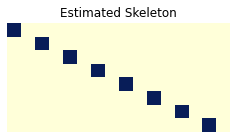

In [94]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(figure_path + '/mocap_skeleton_slow.pdf') as pdf:
    fig = plt.figure(figsize=(4,2))
    sns.heatmap(np.stack(masks), cmap="YlGnBu", cbar=False)
    plt.axis('off')
    plt.title('Estimated Skeleton')
    pdf.savefig(fig, bbox_inches="tight")

In [587]:
y = X3.reshape(batch_size,-1)[:,0]
path = pr_model.path(X, y)

Initialized dense model in 1000 epochs, val loss 4.99e-03, regularization 1.36e-01
Lambda = 4.99e-04, selected 6 features in 15 epochs
val_objective 7.24e-01, val_loss 7.24e-01, regularization 1.39e-01
Lambda = 5.09e-04, selected 6 features in 11 epochs
val_objective 8.10e-01, val_loss 8.10e-01, regularization 1.88e-01
Lambda = 5.19e-04, selected 6 features in 85 epochs
val_objective 3.74e-02, val_loss 3.68e-02, regularization 1.07e+00
Lambda = 5.29e-04, selected 6 features in 10 epochs
val_objective 3.84e-02, val_loss 3.78e-02, regularization 1.08e+00
Lambda = 5.40e-04, selected 6 features in 10 epochs
val_objective 3.81e-02, val_loss 3.75e-02, regularization 1.09e+00
Lambda = 5.51e-04, selected 6 features in 10 epochs
val_objective 3.84e-02, val_loss 3.78e-02, regularization 1.08e+00
Lambda = 5.62e-04, selected 6 features in 10 epochs
val_objective 3.86e-02, val_loss 3.80e-02, regularization 1.08e+00
Lambda = 5.73e-04, selected 6 features in 10 epochs
val_objective 3.83e-02, val_loss

Lambda = 2.16e-03, selected 6 features in 10 epochs
val_objective 2.43e-02, val_loss 2.20e-02, regularization 1.07e+00
Lambda = 2.20e-03, selected 6 features in 10 epochs
val_objective 2.42e-02, val_loss 2.19e-02, regularization 1.07e+00
Lambda = 2.25e-03, selected 6 features in 10 epochs
val_objective 2.42e-02, val_loss 2.17e-02, regularization 1.07e+00
Lambda = 2.29e-03, selected 6 features in 10 epochs
val_objective 2.41e-02, val_loss 2.16e-02, regularization 1.07e+00
Lambda = 2.34e-03, selected 6 features in 10 epochs
val_objective 2.40e-02, val_loss 2.15e-02, regularization 1.07e+00
Lambda = 2.38e-03, selected 6 features in 10 epochs
val_objective 2.40e-02, val_loss 2.14e-02, regularization 1.07e+00
Lambda = 2.43e-03, selected 6 features in 10 epochs
val_objective 2.39e-02, val_loss 2.13e-02, regularization 1.07e+00
Lambda = 2.48e-03, selected 6 features in 10 epochs
val_objective 2.38e-02, val_loss 2.12e-02, regularization 1.07e+00
Lambda = 2.53e-03, selected 6 features in 10 epo

Lambda = 8.99e-03, selected 6 features in 10 epochs
val_objective 2.67e-02, val_loss 1.71e-02, regularization 1.07e+00
Lambda = 9.17e-03, selected 6 features in 10 epochs
val_objective 2.69e-02, val_loss 1.70e-02, regularization 1.07e+00
Lambda = 9.35e-03, selected 6 features in 10 epochs
val_objective 2.71e-02, val_loss 1.70e-02, regularization 1.07e+00
Lambda = 9.54e-03, selected 6 features in 10 epochs
val_objective 2.72e-02, val_loss 1.70e-02, regularization 1.07e+00
Lambda = 9.73e-03, selected 6 features in 10 epochs
val_objective 2.74e-02, val_loss 1.70e-02, regularization 1.07e+00
Lambda = 9.92e-03, selected 6 features in 10 epochs
val_objective 2.76e-02, val_loss 1.70e-02, regularization 1.07e+00
Lambda = 1.01e-02, selected 6 features in 10 epochs
val_objective 2.78e-02, val_loss 1.70e-02, regularization 1.07e+00
Lambda = 1.03e-02, selected 6 features in 10 epochs
val_objective 2.80e-02, val_loss 1.69e-02, regularization 1.07e+00
Lambda = 1.05e-02, selected 6 features in 10 epo

Lambda = 3.67e-02, selected 6 features in 10 epochs
val_objective 5.51e-02, val_loss 1.59e-02, regularization 1.07e+00
Lambda = 3.74e-02, selected 6 features in 10 epochs
val_objective 5.59e-02, val_loss 1.59e-02, regularization 1.07e+00
Lambda = 3.81e-02, selected 6 features in 10 epochs
val_objective 5.66e-02, val_loss 1.59e-02, regularization 1.07e+00
Lambda = 3.89e-02, selected 6 features in 10 epochs
val_objective 5.74e-02, val_loss 1.59e-02, regularization 1.07e+00
Lambda = 3.97e-02, selected 6 features in 10 epochs
val_objective 5.83e-02, val_loss 1.59e-02, regularization 1.07e+00
Lambda = 4.05e-02, selected 6 features in 10 epochs
val_objective 5.91e-02, val_loss 1.58e-02, regularization 1.07e+00
Lambda = 4.13e-02, selected 6 features in 10 epochs
val_objective 5.99e-02, val_loss 1.58e-02, regularization 1.07e+00
Lambda = 4.21e-02, selected 6 features in 10 epochs
val_objective 6.08e-02, val_loss 1.58e-02, regularization 1.07e+00
Lambda = 4.30e-02, selected 6 features in 10 epo

Lambda = 1.50e-01, selected 6 features in 10 epochs
val_objective 1.73e-01, val_loss 1.49e-02, regularization 1.06e+00
Lambda = 1.53e-01, selected 6 features in 10 epochs
val_objective 1.76e-01, val_loss 1.49e-02, regularization 1.06e+00
Lambda = 1.56e-01, selected 6 features in 10 epochs
val_objective 1.79e-01, val_loss 1.49e-02, regularization 1.06e+00
Lambda = 1.59e-01, selected 6 features in 10 epochs
val_objective 1.83e-01, val_loss 1.48e-02, regularization 1.06e+00
Lambda = 1.62e-01, selected 6 features in 10 epochs
val_objective 1.86e-01, val_loss 1.48e-02, regularization 1.06e+00
Lambda = 1.65e-01, selected 6 features in 10 epochs
val_objective 1.89e-01, val_loss 1.48e-02, regularization 1.06e+00
Lambda = 1.68e-01, selected 6 features in 10 epochs
val_objective 1.93e-01, val_loss 1.48e-02, regularization 1.06e+00
Lambda = 1.72e-01, selected 6 features in 10 epochs
val_objective 1.96e-01, val_loss 1.48e-02, regularization 1.06e+00
Lambda = 1.75e-01, selected 6 features in 10 epo

Lambda = 6.10e-01, selected 6 features in 10 epochs
val_objective 6.33e-01, val_loss 1.50e-02, regularization 1.01e+00
Lambda = 6.22e-01, selected 6 features in 10 epochs
val_objective 6.45e-01, val_loss 1.50e-02, regularization 1.01e+00
Lambda = 6.35e-01, selected 6 features in 10 epochs
val_objective 6.57e-01, val_loss 1.50e-02, regularization 1.01e+00
Lambda = 6.47e-01, selected 6 features in 10 epochs
val_objective 6.70e-01, val_loss 1.50e-02, regularization 1.01e+00
Lambda = 6.60e-01, selected 6 features in 10 epochs
val_objective 6.82e-01, val_loss 1.50e-02, regularization 1.01e+00
Lambda = 6.74e-01, selected 6 features in 10 epochs
val_objective 6.95e-01, val_loss 1.50e-02, regularization 1.01e+00
Lambda = 6.87e-01, selected 6 features in 10 epochs
val_objective 7.08e-01, val_loss 1.51e-02, regularization 1.01e+00
Lambda = 7.01e-01, selected 6 features in 10 epochs
val_objective 7.21e-01, val_loss 1.51e-02, regularization 1.01e+00
Lambda = 7.15e-01, selected 6 features in 10 epo

Lambda = 2.44e+00, selected 4 features in 10 epochs
val_objective 2.25e+00, val_loss 2.45e-02, regularization 9.14e-01
Lambda = 2.49e+00, selected 4 features in 10 epochs
val_objective 2.29e+00, val_loss 2.50e-02, regularization 9.12e-01
Lambda = 2.54e+00, selected 4 features in 10 epochs
val_objective 2.34e+00, val_loss 2.55e-02, regularization 9.10e-01
Lambda = 2.59e+00, selected 4 features in 10 epochs
val_objective 2.38e+00, val_loss 2.56e-02, regularization 9.08e-01
Lambda = 2.64e+00, selected 4 features in 10 epochs
val_objective 2.42e+00, val_loss 2.60e-02, regularization 9.05e-01
Lambda = 2.69e+00, selected 4 features in 10 epochs
val_objective 2.46e+00, val_loss 2.66e-02, regularization 9.02e-01
Lambda = 2.75e+00, selected 4 features in 10 epochs
val_objective 2.50e+00, val_loss 2.74e-02, regularization 8.99e-01
Lambda = 2.80e+00, selected 4 features in 10 epochs
val_objective 2.54e+00, val_loss 2.82e-02, regularization 8.96e-01
Lambda = 2.86e+00, selected 4 features in 10 epo

Lambda = 1.04e+01, selected 5 features in 10 epochs
val_objective 6.15e-02, val_loss 3.13e-03, regularization 5.63e-03
Lambda = 1.06e+01, selected 5 features in 10 epochs
val_objective 6.26e-02, val_loss 3.13e-03, regularization 5.63e-03
Lambda = 1.08e+01, selected 5 features in 10 epochs
val_objective 6.38e-02, val_loss 3.14e-03, regularization 5.63e-03
Lambda = 1.10e+01, selected 5 features in 10 epochs
val_objective 6.50e-02, val_loss 3.14e-03, regularization 5.63e-03
Lambda = 1.12e+01, selected 5 features in 10 epochs
val_objective 6.62e-02, val_loss 3.14e-03, regularization 5.63e-03
Lambda = 1.14e+01, selected 5 features in 10 epochs
val_objective 6.75e-02, val_loss 3.14e-03, regularization 5.63e-03
Lambda = 1.17e+01, selected 5 features in 10 epochs
val_objective 6.87e-02, val_loss 3.14e-03, regularization 5.62e-03
Lambda = 1.19e+01, selected 5 features in 10 epochs
val_objective 7.00e-02, val_loss 3.14e-03, regularization 5.62e-03
Lambda = 1.21e+01, selected 5 features in 10 epo

Lambda = 4.23e+01, selected 4 features in 10 epochs
val_objective 2.34e-01, val_loss 3.29e-03, regularization 5.46e-03
Lambda = 4.31e+01, selected 4 features in 10 epochs
val_objective 2.39e-01, val_loss 3.29e-03, regularization 5.46e-03
Lambda = 4.40e+01, selected 4 features in 10 epochs
val_objective 2.43e-01, val_loss 3.30e-03, regularization 5.46e-03
Lambda = 4.48e+01, selected 4 features in 10 epochs
val_objective 2.48e-01, val_loss 3.30e-03, regularization 5.45e-03
Lambda = 4.57e+01, selected 4 features in 10 epochs
val_objective 2.52e-01, val_loss 3.31e-03, regularization 5.45e-03
Lambda = 4.66e+01, selected 4 features in 10 epochs
val_objective 2.57e-01, val_loss 3.31e-03, regularization 5.44e-03
Lambda = 4.76e+01, selected 4 features in 10 epochs
val_objective 2.62e-01, val_loss 3.32e-03, regularization 5.44e-03
Lambda = 4.85e+01, selected 4 features in 10 epochs
val_objective 2.67e-01, val_loss 3.33e-03, regularization 5.44e-03
Lambda = 4.95e+01, selected 4 features in 10 epo

Lambda = 2.14e+02, selected 2 features in 11 epochs
val_objective 1.03e+00, val_loss 7.58e-03, regularization 4.79e-03
Lambda = 2.19e+02, selected 2 features in 11 epochs
val_objective 1.05e+00, val_loss 7.67e-03, regularization 4.78e-03
Lambda = 2.23e+02, selected 2 features in 11 epochs
val_objective 1.07e+00, val_loss 7.76e-03, regularization 4.77e-03
Lambda = 2.27e+02, selected 2 features in 11 epochs
val_objective 1.09e+00, val_loss 7.85e-03, regularization 4.76e-03
Lambda = 2.32e+02, selected 2 features in 11 epochs
val_objective 1.11e+00, val_loss 7.98e-03, regularization 4.75e-03
Lambda = 2.37e+02, selected 2 features in 11 epochs
val_objective 1.13e+00, val_loss 8.17e-03, regularization 4.73e-03
Lambda = 2.41e+02, selected 2 features in 11 epochs
val_objective 1.15e+00, val_loss 8.38e-03, regularization 4.72e-03
Lambda = 2.46e+02, selected 2 features in 11 epochs
val_objective 1.16e+00, val_loss 8.75e-03, regularization 4.69e-03
Lambda = 2.51e+02, selected 2 features in 10 epo

Lambda = 1.07e+03, selected 1 features in 11 epochs
val_objective 3.75e+00, val_loss 3.34e-02, regularization 3.49e-03
Lambda = 1.09e+03, selected 1 features in 11 epochs
val_objective 3.80e+00, val_loss 3.39e-02, regularization 3.47e-03
Lambda = 1.11e+03, selected 1 features in 11 epochs
val_objective 3.86e+00, val_loss 3.43e-02, regularization 3.45e-03
Lambda = 1.13e+03, selected 1 features in 11 epochs
val_objective 3.92e+00, val_loss 3.47e-02, regularization 3.43e-03
Lambda = 1.15e+03, selected 1 features in 11 epochs
val_objective 3.97e+00, val_loss 3.51e-02, regularization 3.41e-03
Lambda = 1.18e+03, selected 1 features in 11 epochs
val_objective 4.03e+00, val_loss 3.54e-02, regularization 3.40e-03
Lambda = 1.20e+03, selected 1 features in 11 epochs
val_objective 4.10e+00, val_loss 3.55e-02, regularization 3.38e-03
Lambda = 1.22e+03, selected 1 features in 11 epochs
val_objective 4.16e+00, val_loss 3.53e-02, regularization 3.37e-03
Lambda = 1.25e+03, selected 1 features in 11 epo

In [584]:
mask

tensor([False,  True, False, False,  True,  True])

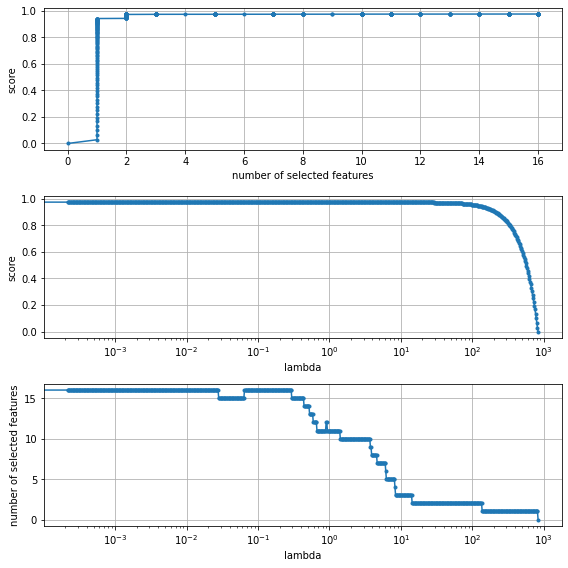

In [86]:
plot_path(pr_model, path, X, y)

In [537]:
out = [ ]
for i in range(3):
    y = X3.reshape(batch_size,-1)[:,i]
    clf = Lasso(alpha=0.0001, normalize=True, max_iter=5000).fit(X, y)
    coef = clf.coef_.reshape(2,3)
    out.append(coef)

In [538]:
out

[array([[0.97761995, 0.        , 0.02464853],
        [0.01462337, 0.01066853, 0.00965156]], dtype=float32),
 array([[-0.        ,  0.8906622 ,  0.        ],
        [-0.00671231,  0.10219645,  0.        ]], dtype=float32),
 array([[-8.3120971e-04, -0.0000000e+00,  9.1457218e-01],
        [-3.9391242e-02, -0.0000000e+00,  7.4293330e-02]], dtype=float32)]

In [532]:
out[2]

array([[ 0.        , -0.        ,  0.9751262 ,  0.        , -0.        ,
        -0.        ,  0.01629186, -0.        ],
       [ 0.        ,  0.09069263,  0.01562128,  0.00903758, -0.        ,
         0.        ,  0.0119777 , -0.        ]], dtype=float32)

In [ ]:
out[3]

In [ ]:
out[6]

In [ ]:
z[:,1]

In [399]:
z.shape

torch.Size([4364, 6, 8])

In [98]:
mu.shape

torch.Size([2560, 6, 8])

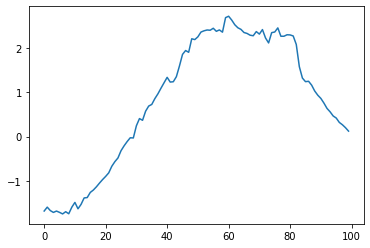

In [289]:
plt.plot(mu[start:end,0,6].detach().numpy())
# plt.plot(z[:300,0,1].detach().numpy())

In [85]:
mu[:300,0].detach().numpy()

array([[-0.04243672, -0.3902921 , -1.0003277 , ..., -0.03542842,
        -1.008788  ,  0.05361128],
       [-0.05133411, -0.37694418, -1.0310696 , ..., -0.03682287,
        -0.9230186 ,  0.04193455],
       [-0.05191309, -0.37330574, -1.0307329 , ..., -0.03854215,
        -0.89342284,  0.04012896],
       ...,
       [-0.15150769, -0.25223267, -0.26817167, ..., -0.02855502,
         1.2452265 , -0.09477242],
       [-0.14803408, -0.25256082, -0.2363221 , ..., -0.03004931,
         1.3152888 , -0.09650569],
       [-0.14322773, -0.24922717, -0.16228047, ..., -0.03252527,
         1.3384143 , -0.0949945 ]], dtype=float32)

In [271]:
batch['s1']['xt'][300:600,0]

tensor([[ 0.3393,  1.5028,  1.4732,  ..., -0.3033,  0.7817,  0.1446],
        [ 0.3666,  1.5100,  1.4818,  ..., -0.3182,  0.7310, -0.0394],
        [ 0.3787,  1.5057,  1.4906,  ..., -0.2822,  0.6649, -0.4909],
        ...,
        [ 0.2765,  0.1853,  1.0480,  ...,  1.4823, -1.8312, -0.7831],
        [ 0.2545,  0.1808,  1.0590,  ...,  1.6312, -1.8080, -1.3100],
        [ 0.2428,  0.1972,  1.0692,  ...,  1.7169, -1.8202, -1.9186]])

In [308]:
batch['s1']['ct'][0:316,0]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [49]:
xt = (data.data['xt'] - data.data['xt'].mean(0))/data.data['xt'].std(0)

In [31]:
X = (data.data['xt'] - data.data['xt'].mean(0))/data.data['xt'].std(0)

In [43]:
np.square(X).mean(0).sum()

62.00000000000001

(array([1.000e+00, 1.600e+01, 9.900e+01, 5.310e+02, 1.032e+03, 1.112e+03,
        9.330e+02, 4.410e+02, 1.580e+02, 4.600e+01]),
 array([-3.89609897, -3.18725706, -2.47841514, -1.76957322, -1.0607313 ,
        -0.35188938,  0.35695253,  1.06579445,  1.77463637,  2.48347829,
         3.19232021]),
 <BarContainer object of 10 artists>)

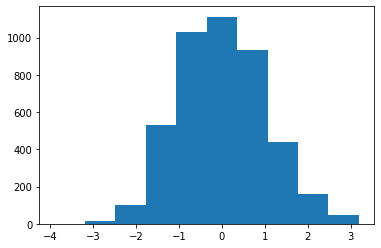

In [37]:
plt.hist(X[:,3])

In [33]:
X.shape

(4369, 62)

In [19]:
data.data['ct']

array([[ 0.],
       [ 0.],
       [ 0.],
       ...,
       [11.],
       [11.],
       [11.]])

In [26]:
data.__getitem__(5)['s1']['xt'].shape

torch.Size([4, 62])